# Introduction

**Survival Analysis** merupakan salah satu metode statistika untuk melakukan analisis lama waktu yang diperlukan hingga terjadinya suatu kejadian. Survival Analysis sering disebut juga sebagai **time-to-event analysis**. Melalui metode survival analysis ini, kita dapat melakukan perencanaan dengan baik atau mengambil langkah antisipasi terhadap suatu kejadian yang tidak diinginkan. Survival analysis pertama kali dikembangkan di bidang kedokteran untuk melihat pengaruh suatu treatment medis terhadap kesintasan pasien hingga meninggal dunia. Selain penerapan di bidang kedokteran, metode ini dapat diaplikasikan pada beberapa bidang atau industri berikut:

1. **Manufacturing** : Memprediksi durasi mesin tetap berjalan hingga rusak
2. **Marketing** : Memprediksi durasi berlangganan seorang konsumen hingga berhenti berlangganan
3. **Human Resources** : Memprediksi durasi seorang karyawan tetap bekerja hingga resign

## Survival Analysis vs Regression

Sejauh ini kita telah ketahui bahwa survival analysis dapat digunakan untuk memprediksi lama waktu hingga terjadinya suatu kejadian. Lalu, mengapa kita tidak menggunakan model regresi biasa yang dapat digunakan untuk memprediksi suatu nilai numerik?

Untuk menjawab hal tersebut, kita perlu memahami konsep **censored observation** yaitu observasi yang belum diketahui secara pasti apakah kapan observasi tersebut mengalami kejadian. Tipe-tipe *censored observation*:

1. **Right censored** : Observasi yang hingga batas akhir pengamatan tidak mengalami kejadian. Contoh: Seorang dokter mengamati kejadian kematian pada pasiennya yang terkena penyakit diabetes selama 12 bulan sejak didiagnosis penyakit tersebut. Jika terdapat pasien yang tidak meninggal selama 12 bulan tersebut maka observasi tersebut disebut *right censored*
2. **Left censored** : Observasi yang sudah mengalami kejadian sebelum waktu pengamatan dimulai. Contoh: Seseorang sudah terkena penyakit diabetes sebelum dokter mengamati pasien tersebut lebih lanjut.
3. **Interval censored** : Observasi yang tidak diketahui secara pasti kapan mengalami kejadian. Contoh: Seorang teknisi mesin mengamati unit-unit mesin hingga mesin tersebut rusak selama 3 bulan sekali. Misalkan terdapat mesin yang mati saat diamati pada bulan ke-9. Kita tidak ketahui secara pasti kapan mesin tersebut rusak namun yang kita ketahui adalah mesin tersebut rusak diantara bulan ke-6 dan ke-9.

Adanya *censored observation* tersebut yang membuat kita tidak dapat menggunakan model regresi biasa. Pada metode survival analysis ini, observasi *right censored* yang akan kita gunakan karena tipe observasi tersebut sering muncul.

## Konsep Matematika

Misalkan $T$ adalah peubah acak yang menyatakan waktu hingga terjadinya suatu kejadian. Maka

1. **Fungsi Kepadatan Peluang (*Probability Density Function*, PDF)** $f(t) = P(T = t)$: peluang suatu kejadian terjadi saat waktu $t$
2. **Fungsi Distribusi Kumulatif (*Cumulative Distribution Function*, CDF)** $F(t) = P(T <= t)$: peluang suatu kejadian terjadi sebelum waktu $t$. Secara matematis, CDF dapat didefinisikan sebagai berikut:
$$
F(t) = \int_{0}^{t}{f(s)} ds
$$
3. **Fungsi Distribusi Survival (*Survival Distribution Function*, SDF)** $S(t) = P(T>t)$: peluang suatu kejadian terjadi setelah waktu $t$. Secara matematis, SDF dapat didefinisikan sebagai berikut:
$$
S(t) = 1 - F(t)
$$
4. **Fungsi Hazard (*Hazard Rate Function/Force of Mortality*)** $h(t)$ : peluang bersyarat terjadinya suatu kejadian saat waktu $t$ diketahui subjek yang diamati belum mengalami kejadian saat waktu $t$. Secara matematis, fungsi hazard dapat diperoleh sebagai berikut:
$$
h(t) = - \frac{d}{dt} ln(S(t))
$$

Hubungan antara $f(t), F(t), S(t), h(t)$ dapat dilihat pada diagram berikut

**Insert diagram here**

# Import Library

In [1]:
# install sksurv package
# ! pip install scikit-survival

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(rc = {'figure.figsize':(16,9)})

# Import Data and Preprocessing

Kita akan menggunakan [dataset mesin NASA](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps) yang pada setiap barisnya berisi banyak siklus yang telah dilakukan suatu mesin. Pada setiap siklus tersebut dilakukan pengaturan terhadap tiga jenis pengaturan operasional kemudian dicatat berdasarkan 22 pengukuran yang berbeda.

In [3]:
# Define columns name
column1 = ["machine_id", "cycle", "operational_setting_1", "operational_setting_2", "operational_setting_3"]
column2 = [f'sensor_{i:02}' for i in range(1,22)]
columns = column1 + column2

In [4]:
# Read data
turbofan_df = pd.read_csv("./CMaps/train_FD002.txt", header = None, sep = "\s+", names = columns)
turbofan_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\867821110.py:2: SyntaxWarning: invalid escape sequence '\s'
  turbofan_df = pd.read_csv("./CMaps/train_FD002.txt", header = None, sep = "\s+", names = columns)


,machine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Create Censored Data

Jika kita lihat pada data di atas, data yang kita miliki bukanlah data yang memiliki observasi *right censored*. Untuk mendapatkan observasi tersebut, kita lakukan tahapan berikut:

1. Memilih siklus maksimum hingga mesin rusak pada setiap mesin
2. Mengasumsikan batas akhir waktu pengamatan

In [5]:
# Menambahkan kolom max_cycle untuk setiap machine_id yang menunjukkan cycle maksimum
turbofan_df['max_cycle'] = turbofan_df.groupby(by="machine_id")['cycle'].transform('max')

# Menampilkan beberapa baris pertama dari turbofan_df
turbofan_df.head()


,machine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,149
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,149


In [6]:
# Select maximum cycle
max_cycle = turbofan_df.groupby(by = "machine_id")['cycle'].transform(max)
turbofan_df = turbofan_df[turbofan_df["cycle"] == max_cycle].set_index('machine_id')
turbofan_df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\969144477.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_cycle = turbofan_df.groupby(by = "machine_id")['cycle'].transform(max)


,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle
machine_id,,,,,,,,,,,,,,,,,,,,,
1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,5.71,...,2387.40,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285,149
2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,5.72,...,2388.42,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615,269
3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,5.72,...,2387.87,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349,206
4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,21.61,...,2388.17,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717,235
5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,5.72,...,2389.19,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906,154


Selanjutnya, kita buat lollipop plot untuk memperoleh distribusi siklus maksimum pada setiap mesin

In [7]:
# Create status column
turbofan_df['status'] = turbofan_df['cycle'].apply(lambda x: 0 if x > 200 else 1)

# Menampilkan beberapa baris pertama setelah penambahan kolom 'status'
turbofan_df

,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,status
machine_id,,,,,,,,,,,,,,,,,,,,,
1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,5.71,...,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285,149,1
2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,5.72,...,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615,269,0
3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,5.72,...,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349,206,0
4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,21.61,...,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717,235,0
5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,5.72,...,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906,154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,163,0.0019,0.0003,100.0,518.67,643.15,1597.21,1425.84,14.62,21.61,...,8128.22,8.5586,0.03,396,2388,100.0,38.62,23.0771,163,1
257,309,42.0077,0.8411,100.0,445.00,550.84,1369.00,1146.53,3.91,5.72,...,8171.37,9.4156,0.02,336,2212,100.0,10.47,6.3085,309,0
258,143,9.9984,0.2500,100.0,489.05,606.05,1513.93,1326.79,10.52,15.50,...,8124.16,8.7392,0.03,372,2319,100.0,28.32,16.9473,143,1


In [8]:
# Distribution of each status
turbofan_df['status'].value_counts()

status
1    136
0    124
Name: count, dtype: int64

# Exploratory Data Analysis

Langkah selanjutnya adalah melakukan *feature selection* yaitu pemilihan kolom/variabel yang dapat dimasukkan ke dalam model

## Check Uniqueness

Pertama kita akan memeriksa banyak nilai unik pada setiap kolom lalu kolom yang memiliki nilai unik yang sedikit akan diganti dengan tipe data kategori.

In [9]:
turbofan_df.nunique()

cycle                    133
operational_setting_1    165
operational_setting_2     62
operational_setting_3      2
sensor_01                  6
sensor_02                188
sensor_03                257
sensor_04                251
sensor_05                  6
sensor_06                  8
sensor_07                209
sensor_08                177
sensor_09                259
sensor_10                  8
sensor_11                123
sensor_12                198
sensor_13                152
sensor_14                258
sensor_15                247
sensor_16                  2
sensor_17                 27
sensor_18                  6
sensor_19                  2
sensor_20                135
sensor_21                253
max_cycle                133
status                     2
dtype: int64

> Kolom yang dapat diganti ke tipe kategori: `operational_setting_3`, `sensor_16`

In [10]:
# Change to category
category_columns = ['operational_setting_3', 'sensor_16']

turbofan_df[category_columns] = turbofan_df[category_columns].astype('category')
turbofan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, 1 to 260
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cycle                  260 non-null    int64   
 1   operational_setting_1  260 non-null    float64 
 2   operational_setting_2  260 non-null    float64 
 3   operational_setting_3  260 non-null    category
 4   sensor_01              260 non-null    float64 
 5   sensor_02              260 non-null    float64 
 6   sensor_03              260 non-null    float64 
 7   sensor_04              260 non-null    float64 
 8   sensor_05              260 non-null    float64 
 9   sensor_06              260 non-null    float64 
 10  sensor_07              260 non-null    float64 
 11  sensor_08              260 non-null    float64 
 12  sensor_09              260 non-null    float64 
 13  sensor_10              260 non-null    float64 
 14  sensor_11              260 non-null    float64 

In [11]:
# Melihat deskriptif statistik dari data numerik
descriptive_stats = turbofan_df.describe()
descriptive_stats

,cycle,operational_setting_1,operational_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,status
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,...,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,206.765385,27.937113,0.598383,466.689346,575.619115,1425.801000,1218.674692,7.124231,10.386385,255.637115,...,2364.920731,8105.652538,9.288340,349.815385,2242.073077,99.014654,18.644115,11.185072,206.765385,0.523077
std,46.782198,16.564435,0.324420,27.479073,36.085540,97.552983,114.934975,3.949434,5.864195,153.443600,...,89.267941,74.714146,0.584163,25.629762,108.889934,3.732538,10.443101,6.261529,46.782198,0.500430
min,128.000000,0.000100,0.000000,445.000000,536.620000,1263.290000,1058.960000,3.910000,5.710000,136.990000,...,2027.610000,7850.960000,8.486100,309.000000,1915.000000,84.930000,10.270000,6.164800,128.000000,0.000000
25%,174.000000,10.003225,0.250650,445.000000,550.477500,1364.650000,1143.535000,3.910000,5.720000,138.277500,...,2387.970000,8081.580000,8.753125,334.000000,2212.000000,100.000000,10.470000,6.283750,174.000000,0.000000
50%,199.000000,41.998300,0.840000,445.000000,550.880000,1370.270000,1147.880000,3.910000,5.720000,139.165000,...,2388.320000,8116.755000,9.414700,335.000000,2212.000000,100.000000,10.685000,6.390250,199.000000,1.000000
75%,230.250000,42.002625,0.840100,489.050000,606.042500,1512.122500,1329.327500,10.520000,15.500000,392.595000,...,2388.752500,8148.730000,9.456725,372.000000,2319.000000,100.000000,28.210000,16.925775,230.250000,1.000000
max,378.000000,42.007900,0.842000,518.670000,644.260000,1609.460000,1438.160000,14.620000,21.610000,551.980000,...,2390.390000,8252.610000,11.045400,398.000000,2388.000000,100.000000,38.680000,23.153900,378.000000,1.000000


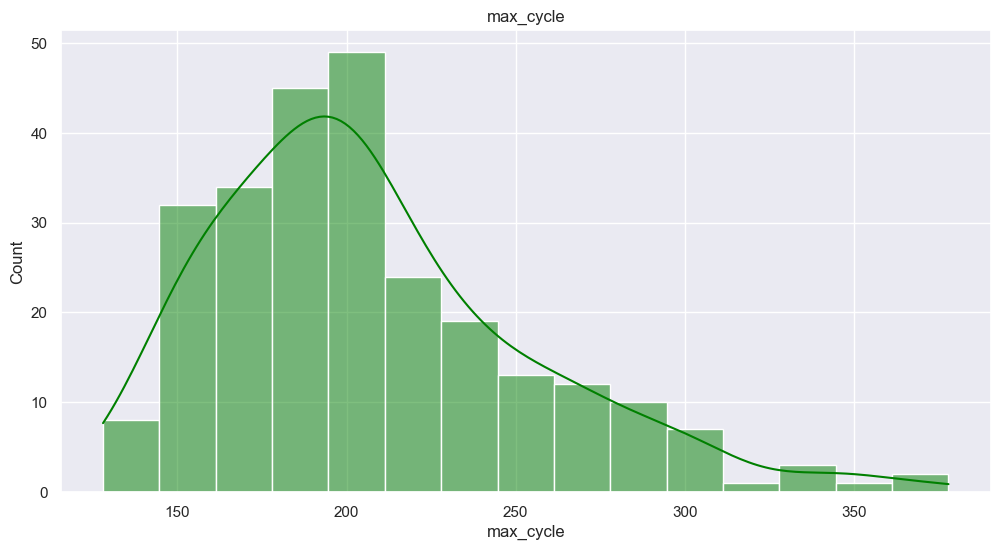

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(turbofan_df['max_cycle'], kde=True, color='green')
plt.title('max_cycle')
plt.show()

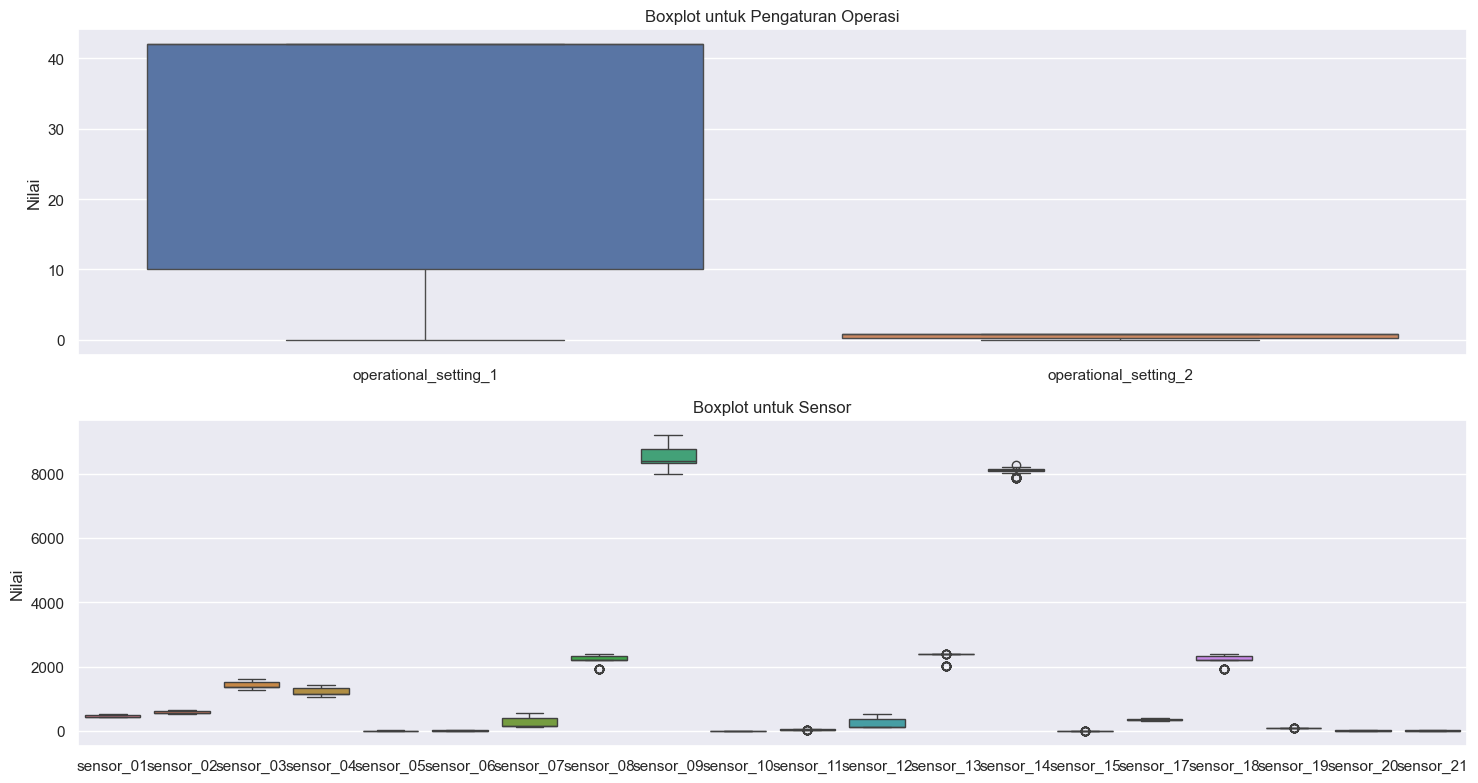

In [13]:
# Visualisasi boxplot untuk setiap sensor dan pengaturan operasi
operation_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']
sensor_columns = [f'sensor_{i:02}' for i in range(1, 22)]

plt.figure(figsize=(15, 8))

# Boxplot untuk pengaturan operasi
plt.subplot(2, 1, 1)
sns.boxplot(data=turbofan_df[operation_columns])
plt.title('Boxplot untuk Pengaturan Operasi')
plt.ylabel('Nilai')

# Boxplot untuk sensor
plt.subplot(2, 1, 2)
sns.boxplot(data=turbofan_df[sensor_columns])
plt.title('Boxplot untuk Sensor')
plt.ylabel('Nilai')

plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\1955596486.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=turbofan_df, palette='pastel')


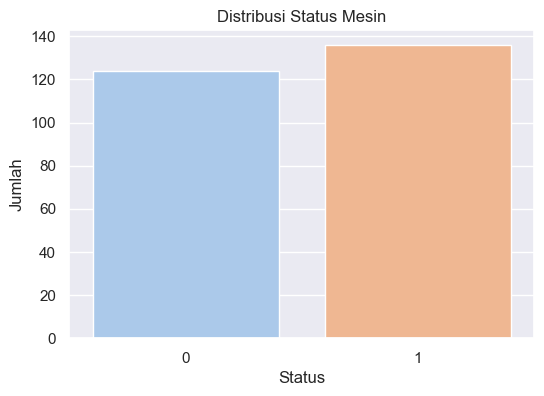

In [14]:
# Visualisasi distribusi status
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=turbofan_df, palette='pastel')
plt.title('Distribusi Status Mesin')
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\2601144799.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sensor_16', data=turbofan_df, palette='pastel')


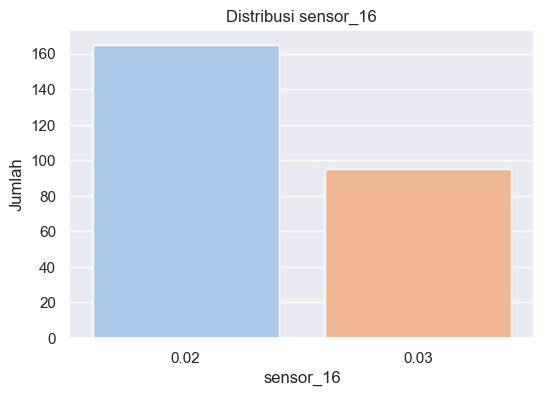

In [15]:
# Visualisasi distribusi status
plt.figure(figsize=(6, 4))
sns.countplot(x='sensor_16', data=turbofan_df, palette='pastel')
plt.title('Distribusi sensor_16')
plt.xlabel('sensor_16')
plt.ylabel('Jumlah')
plt.show()


## Pemilihan fitut

1. **Setting 1 (Altitude)** - Numerik
    
    Altitude atau ketinggian mempengaruhi performa mesin. Mesin turbofan beroperasi dalam kondisi atmosfer yang berbeda pada berbagai ketinggian, yang dapat mempengaruhi efisiensi dan keausan mesin. Variabel ini relevan karena kondisi ketinggian dapat mempercepat kerusakan pada mesin.
    
2. **Setting 2 (Mach Number)** - Numerik
    
    Mach Number menggambarkan kecepatan pesawat relatif terhadap kecepatan suara. Pada kecepatan tinggi (Mach 1 atau lebih), mesin beroperasi dalam kondisi yang lebih ekstrem, yang dapat berhubungan langsung dengan keausan atau kerusakan komponen mesin. Oleh karena itu, variabel ini penting dalam model survival.
    
3. **Setting 3 (Sea-level Temperature)** - Kategorik
    
    Sea-level Temperature menggambarkan suhu di permukaan laut yang mempengaruhi kondisi atmosfer dan performa mesin. Suhu yang lebih tinggi atau lebih rendah dapat berdampak pada efisiensi mesin dan kerusakan. Variabel ini perlu diencode karena bersifat kategorik.
    
4. **Sensor 1 (T2)** - Numerik
    
    T2 adalah suhu pada inlet fan mesin, yang berperan penting dalam mendeteksi masalah pada mesin. Suhu yang tinggi pada bagian ini menunjukkan potensi masalah yang dapat mempercepat kerusakan mesin. Oleh karena itu, variabel ini relevan dalam analisis survival untuk mendeteksi kerusakan mesin lebih awal.
    
5. **Sensor 8 (Nf)** - Numerik
    
    Kecepatan fan (**Nf**) adalah indikator penting untuk memahami kondisi operasional mesin. Kecepatan fan yang rendah atau tinggi dapat menunjukkan masalah pada mesin, yang berhubungan dengan potensi kegagalan. Variabel ini memberikan informasi yang penting untuk model survival.
    
6. **Sensor 9 (Nc)** - Numerik
    
    Kecepatan inti (**Nc**) adalah parameter lain yang menggambarkan performa mesin. Kecepatan inti yang tidak stabil dapat menunjukkan masalah pada mesin dan menjadi tanda awal untuk prediksi kegagalan.
    
7. **Sensor 10 (epr)** - Numerik
    
    Engine Pressure Ratio (**epr**) mengukur efisiensi mesin dan menunjukkan apakah mesin bekerja dalam kondisi optimal. Penurunan rasio ini dapat menjadi indikasi bahwa mesin sedang mengalami penurunan performa yang dapat berujung pada kegagalan.
    
8. **Sensor 16 (farB)** - Kategorik
    
    **farB** atau Burner fuel-air ratio adalah rasio antara bahan bakar dan udara yang digunakan dalam proses pembakaran. Variabel ini hanya memiliki dua kondisi (misalnya, normal atau tidak normal) dan memengaruhi efisiensi pembakaran. Ketidakseimbangan dalam rasio ini dapat menyebabkan keausan atau kerusakan pada mesin, sehingga perlu diperlakukan sebagai variabel kategorik.

# Data Preparation for Modeling

Langkah selanjutnya adalah menyiapkan data untuk melakukan pemodelan. Hal yang perlu diperhatikan adalah:

1. Untuk kolom dengan tipe kategori perlu dilakukan One Hot Encoding
2. Untuk data target, perlu dituliskan dalam bentuk array dengan setiap elemennya adalah sebuah tuple yang terdiri dari status mesin (True/False) dan waktu/siklusnya

In [16]:
cleaned_data = turbofan_df[['cycle', 'status', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 
                            'sensor_01', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_16']]

In [17]:
# One Hot Encoding for Categorical Variable
from sksurv.preprocessing import OneHotEncoder

# Pilih variabel kategorik untuk encoding (operational_setting_3 dan sensor_16)
categorical_columns = ['operational_setting_3', 'sensor_16']

# Terapkan OneHotEncoder hanya pada kolom kategorik
encoder = OneHotEncoder()
data_x = encoder.fit_transform(cleaned_data[categorical_columns])

# Gabungkan hasil encoding dengan kolom numerik lainnya
numerical_columns = ['cycle', 'status', 'operational_setting_1', 'operational_setting_2', 
                     'sensor_01', 'sensor_08', 'sensor_09', 'sensor_10']
data_x = pd.concat([cleaned_data[numerical_columns], pd.DataFrame(data_x, columns=encoder.get_feature_names_out())], axis=1)

# Tampilkan beberapa baris pertama untuk memeriksa
data_x.head()

,cycle,status,operational_setting_1,operational_setting_2,sensor_01,sensor_08,sensor_09,sensor_10,operational_setting_3=100.0,sensor_16=0.03
machine_id,,,,,,,,,,
1,149,1,42.0017,0.8414,445.00,2211.38,8307.72,1.02,1.0,0.0
2,269,0,42.0047,0.8411,445.00,2212.32,8358.80,1.02,1.0,0.0
3,206,0,42.0073,0.8400,445.00,2211.81,8329.26,1.02,1.0,0.0
4,235,0,0.0030,0.0007,518.67,2388.17,9150.14,1.30,1.0,1.0
5,154,1,42.0049,0.8408,445.00,2212.99,8397.52,1.02,1.0,0.0


In [18]:
# Preprocessing for target variable
data_y = list(cleaned_data.loc[:, ["status", "cycle"]].itertuples(index = None, name = None))
data_y = np.array(data_y, dtype=[('status', bool), ('cycle', float)])
data_y[:5]

array([( True, 149.), (False, 269.), (False, 206.), (False, 235.),
       ( True, 154.)], dtype=[('status', '?'), ('cycle', '<f8')])

# Kaplan Meier Estimator

Dari data yang telah kita miliki di atas maka kita dapat membangun fungsi survival **Kaplan Meier Estimator**. Kaplan Meier Estimator dibangun dengan menghitung peluang observasi yang survive (tidak mengalami kejadian) pada setiap waktu. Secara matematis, Kaplan Meier Estimator dapat dituliskan sebagai berikut:
$$
S(t) = \prod_{j=1}^{t} \frac{n_j - d_j}{n_j} 
$$
dengan $n_j$ adalah banyaknya subject saat waktu $j$ dan $d_j$ adalah banyaknya subject yang mengalami kejadian.

Sebagai ilustrasi, misalkan kita memiliki data berikut

| ID | Waktu | Event |
| --- | --- | --- |
| 1 | 6 | 1 |
| 2 | 40 | 0 |
| 3 | 21 | 1 |
| 4 | 14 | 1 |
| 5 | 40 | 0 |

Maka,
1. Untuk waktu $0 \leq t < 6$, terdapat 5 observasi dan tidak terdapat observasi yang mengalami event. Maka
$$S(t) = \frac{5-0}{5} = 1 $$
2. Untuk waktu $6 \leq t < 14$ terdapat 5 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{5-1}{5} = \frac{4}{5} = 0.8$$
3. Untuk waktu $14 \leq t < 21$ terdapat 4 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} = \frac{3}{5} = 0.6$$
4. Untuk waktu $21 \leq t < 40$ terdapat 3 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} * \frac{3-1}{3} = \frac{2}{5} = 0.4$$
5. Untuk waktu $t \geq 40$ tersisa 2 observasi dan tidak terdapat observasi yang mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} * \frac{3-1}{3} * \frac{2-0}{2} = 0.4$$

Berikut adalah cara untuk membangun fungsi survival menggunakan Kaplan Meier Estimator menggunakan package `sksurv`

**Interpretasi:**

1. Hingga saat $t=125$ nilai $S(t)=1$ yang menunjukkan bahwa semua mesin tetap hidup hingga siklus ke-125
2. Saat $t=175$ nilai $S(t)$ berada di sekitar 0.75 menunjukkan bahwa setelah terdapat sekitar 75% mesin tetap hidup hingga siklus ke 175
3. Peluang mesin tetap hidup menjadi 50% setelah siklus ke-190

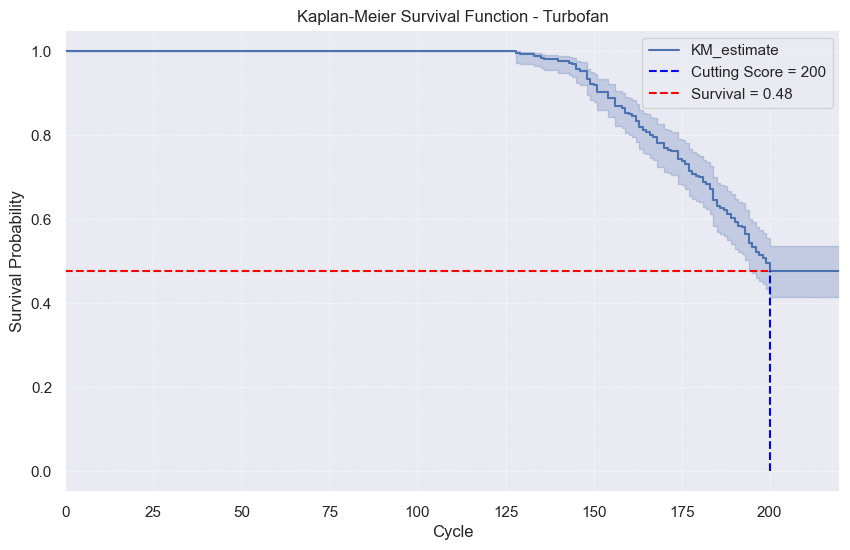

In [19]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Membuat dan menyesuaikan Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(durations=turbofan_df['max_cycle'], event_observed=turbofan_df['status'])

# Plot Kaplan-Meier Survival Function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

# Menyesuaikan timeline axis X untuk interval 25 siklus, dengan batas sampai sedikit lebih dari 200
plt.xticks(range(0, 225, 25))
plt.xlim(0, 220)

# Interpolasi untuk menentukan nilai survival probability pada cutting score
cutting_score = 200
survival_at_cutting = np.interp(cutting_score, kmf.survival_function_.index, kmf.survival_function_["KM_estimate"])

# Membatasi garis vertikal dan horizontal hanya sampai kurva
plt.plot([cutting_score, cutting_score], [0, survival_at_cutting], color='blue', linestyle='--', label=f"Cutting Score = {cutting_score}")
plt.plot([0, cutting_score], [survival_at_cutting, survival_at_cutting], color='red', linestyle='--', label=f"Survival = {survival_at_cutting:.2f}")


# Menambahkan judul, label, dan legend
plt.title("Kaplan-Meier Survival Function - Turbofan")
plt.xlabel("Cycle")
plt.ylabel("Survival Probability")
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="best")

# Menampilkan plot
plt.show()


## Compare Survival Time for Each Category in Every Categorical Columns

Kita telah mempelajari bagaimana membangun fungsi survival menggunakan Kaplan Meier Estimator. Terkadang kita ingin melakukan perbandingan apakah adanya perbedaan kategori/perlakuan akan memengaruhi kesintasan subjek yang kita amati.

Misalkan, pada data `cleaned_data` kita memiliki dua buah kolom yang memiliki tipe kategori yaitu `operational_setting_3` dan `sensor_16`. Mari kita periksa banyaknya nilai unik pada kedua kolom tersebut

In this section, we will compare the distribution of survival time for each category in every categorical columns. From the distribution we hope that we can determined if there is a difference distribution for each category or not.

In [20]:
os3_unique = list(cleaned_data['operational_setting_3'].unique())
sm16_unique = list(cleaned_data['sensor_16'].unique())
print(f'Nilai unik operational_setting_3: {os3_unique}')
print(f'Nilai unik sensor_16: {sm16_unique}')

Nilai unik operational_setting_3: [100.0, 60.0]
Nilai unik sensor_16: [0.02, 0.03]


Sekarang kita akan melakukan perbandingan distribusi fungsi survival antara nilai 100 dan 60 pada kolom `operational_setting_3`

<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\10580014.py:11: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("est. probability of survival $\hat{S}(t)$")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\10580014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['status'] = cleaned_data['status'].astype(bool)


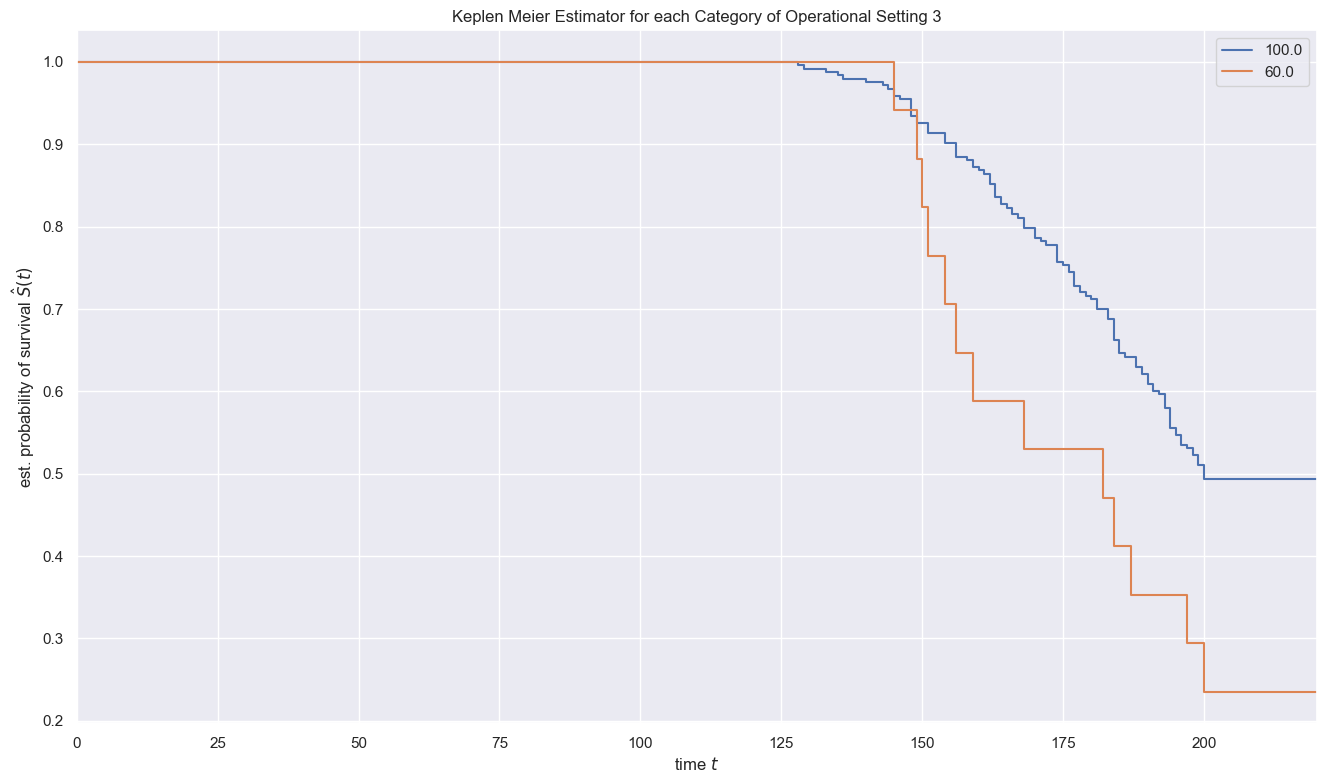

In [21]:
from sksurv.nonparametric import kaplan_meier_estimator
cleaned_data['status'] = cleaned_data['status'].astype(bool)

for category in cleaned_data['operational_setting_3'].unique():
    category_df = cleaned_data[cleaned_data['operational_setting_3'] == category]
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(category_df['status'],
                                                                     category_df['cycle'])
    time_treatment , survival_prob_treatment = np.append(0, time_treatment), np.append(1, survival_prob_treatment)
    plt.step(time_treatment, survival_prob_treatment, where = "post", label = category)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title(f"Keplen Meier Estimator for each Category of Operational Setting 3")
plt.legend(loc="best")
plt.xlim(left = 0, right = 220)
plt.show()

> **Interpretasi**: Berdasarkan visualisasi di atas, dapat kita lihat bahwa nilai `operational_setting_3 = 100` cenderung memiliki nilai fungsi survival yang lebih tinggi dibandingkan `operational_setting_3 = 60` yang menunjukkan bahwa `operational_setting_3 = 100` lebih tahan lama dibandingkan `operational_setting_3 = 60`

In [22]:
from lifelines.statistics import logrank_test

# Filter data untuk kedua kategori
group1 = cleaned_data[cleaned_data['operational_setting_3'] == 100.0]
group2 = cleaned_data[cleaned_data['operational_setting_3'] == 60.0]

# Uji log-rank
results = logrank_test(group1['cycle'], group2['cycle'], event_observed_A=group1['status'], event_observed_B=group2['status'])

# Menampilkan hasil uji log-rank
print(f"Log-Rank Test result for operational_setting_3: 100.0 vs 60.0")
print(results)


Log-Rank Test result for operational_setting_3: 100.0 vs 60.0
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.72 0.01      6.71


Hal yang sama kita lakukan untuk kolom `sensor_16`

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_49332\404113194.py:8: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("est. probability of survival $\hat{S}(t)$")


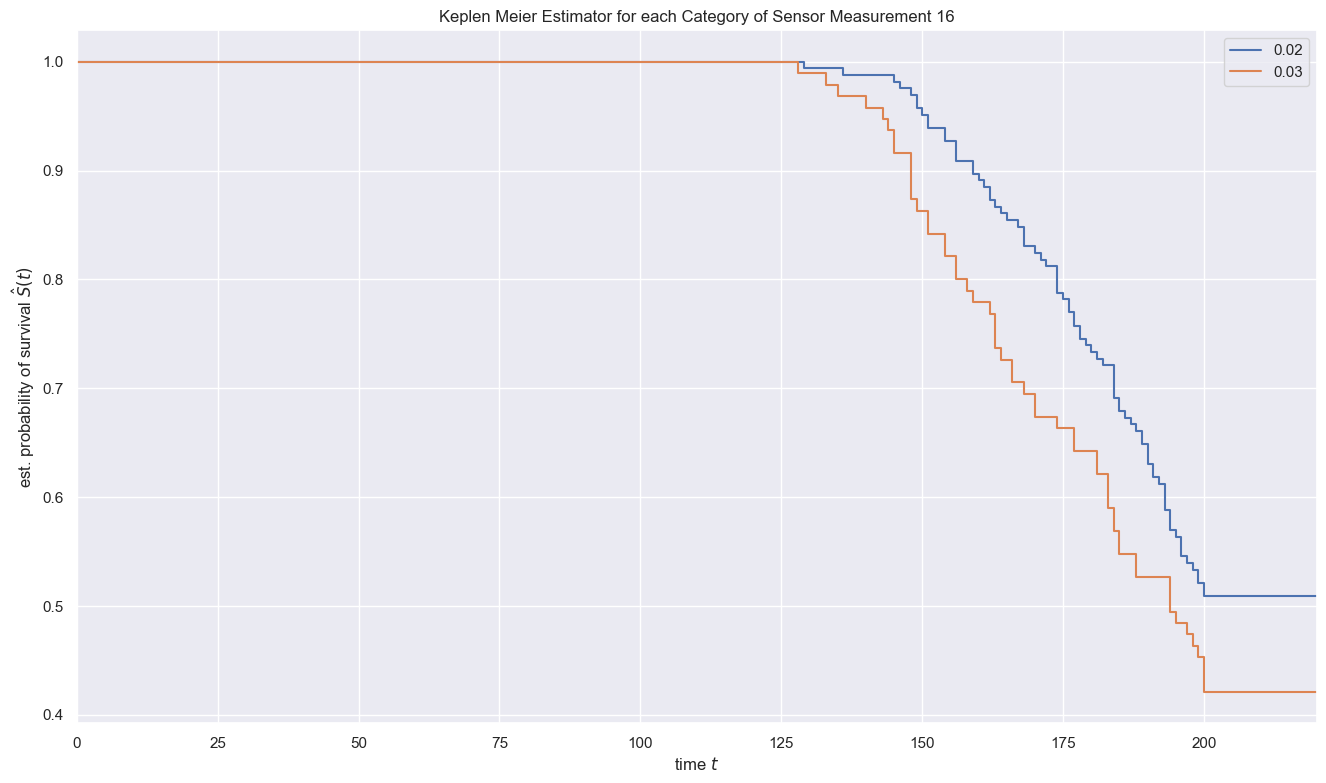

In [23]:
for category in cleaned_data['sensor_16'].unique():
    category_df = cleaned_data[cleaned_data['sensor_16'] == category]
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(category_df['status'],
                                                                     category_df['cycle'])
    time_treatment , survival_prob_treatment = np.append(0, time_treatment), np.append(1, survival_prob_treatment)
    plt.step(time_treatment, survival_prob_treatment, where = "post", label = category)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title(f"Keplen Meier Estimator for each Category of Sensor Measurement 16")
plt.legend(loc="best")
plt.xlim(left = 0, right = 220)
plt.show()

> **Interpretasi**: Berdasarkan visualisasi di atas, dapat kita lihat bahwa nilai `sensor_16 = 0.02` cenderung memiliki nilai fungsi survival yang lebih tinggi dibandingkan `sensor_16 = 0.03` (walaupun tidak berbeda jauh secara signifikan) yang menunjukkan bahwa `sensor_16 = 0.02` lebih tahan lama dibandingkan `sensor_16 = 0.03`

In [24]:
from lifelines.statistics import logrank_test

# Membuat subset data untuk setiap kategori sensor_16
group_1 = cleaned_data[cleaned_data['sensor_16'] == 0.02]
group_2 = cleaned_data[cleaned_data['sensor_16'] == 0.03]

# Menghitung log-rank test antara dua grup
result = logrank_test(group_1['cycle'], group_2['cycle'], event_observed_A=group_1['status'], event_observed_B=group_2['status'])

# Menampilkan hasil Log-Rank Test
print("Log-Rank Test result for sensor_16: 0.02 vs 0.03")
print(result)


Log-Rank Test result for sensor_16: 0.02 vs 0.03
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.10 0.08      3.68


# Log-Rank Test

Pada bagian sebelumnya, kita telah melakukan perbandingan distribusi fungsi survival melalui visualisasi. Namun terkadang kita memerlukan uji statistik lebih lanjut untuk memastikan apakah kedua distribusi tersebut dapat dikatakan sama atau berbeda secara signifikan. Untuk melakukan pengujian tersebut, kita dapat menggunakan **Log-Rank Test** dengan hipotesis

$H_{0}$ : Distribusi kedua fungsi survival sama

$H_{1}$ : Distribusi kedua fungsi survival berbeda


In [25]:
from sksurv.compare import compare_survival

p_value_list = []
for column in category_columns:
    p_value = compare_survival(data_y, turbofan_df[column])[1]
    p_value_list.append(p_value)
    
result = pd.DataFrame({'columns': category_columns, 'p-value': p_value_list}).set_index('columns')
result['conclusion'] = result['p-value'].apply(lambda x: "significant" if x < 0.05 else "not significant")
result

,p-value,conclusion
columns,,
operational_setting_3,0.009559,significant
sensor_16,0.078070,not significant


> **Kesimpulan** : Untuk kolom `operational_setting_3` terdapat perbedaan distribusi fungsi survival pada setiap kategorinya sedangkan untuk kolom `sensor_16` tidak terdapat perbedaan yang signifikan

Karena tidak terdapat perbedaan yang signifikan pada setiap kategorinya, maka kita dapat menghapus variabel `sensor_16` pada data kita

In [33]:
data_x = data_x[data_x.columns[~data_x.columns.isin(["sensor_16=0.03"])]]

In [34]:
data_x

,cycle,status,operational_setting_1,operational_setting_2,sensor_01,sensor_08,sensor_09,sensor_10,operational_setting_3=100.0
machine_id,,,,,,,,,
1,149,1,42.0017,0.8414,445.00,2211.38,8307.72,1.02,1.0
2,269,0,42.0047,0.8411,445.00,2212.32,8358.80,1.02,1.0
3,206,0,42.0073,0.8400,445.00,2211.81,8329.26,1.02,1.0
4,235,0,0.0030,0.0007,518.67,2388.17,9150.14,1.30,1.0
5,154,1,42.0049,0.8408,445.00,2212.99,8397.52,1.02,1.0
...,...,...,...,...,...,...,...,...,...
256,163,1,0.0019,0.0003,518.67,2388.32,9064.79,1.30,1.0
257,309,0,42.0077,0.8411,445.00,2213.35,8421.85,1.03,1.0
258,143,1,9.9984,0.2500,489.05,2319.17,8783.40,1.26,1.0


# Cox Propotional Hazard

Model **Cox Propotional Hazard (CoxPH)** dapat digunakan untuk melakukan pemodelan terdahap Data Survival. Secara matematis, model ini dapat dituliskan sebagai berikut:
$$
h(t) = h_{0}(t) e^{\beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n}}
$$

Model CoxPH ini adalah model semiparametric yang akan memprediksi nilai hazard rate yang terdiri dari komponen:

- Non-parametrik $h_{0}(t)$ (*baseline hazard*) : Karakterisasi mengenai bagaimana fungsi hazard berubah seiring berjalannya waktu. Baseline hazard ini dapat diinterpretasikan juga sebagai intercept pada masalah regresi
- Parametrik $e^{\beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n}}$ : Karakterisasi mengenai bagaimana fungsi hazard berubah berdasarkan kondisi kovariat (variabel yang terlibat dalam model)

Untuk memperoleh fungsi survival berdasarkan model di atas, kita dapat memanfaatkan hubungan berikut:
$$
S(t) = e^{-\int{h(t)}} dt
$$

Kita dapat memanfaatkan fungsi `CoxPHSurvivalAnalysis` dari package `sksurv` untuk membangun model CoxPH. Pada kasus ini, kita gunakan parameter `alpha = 1e-4` sebagai untuk regularisasi. Dokumentasi lebih lengkap untuk penggunaan fungsi ini dapat dilihat pada [dokumentasi berikut](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html)

In [35]:
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.preprocessing import StandardScaler

# 1. Standardisasi data
scaler = StandardScaler()
data_x_scaled = scaler.fit_transform(data_x)
data_x_scaled = pd.DataFrame(data_x_scaled, columns=data_x.columns)

# 2. Cek dan hapus kolom dengan variance rendah
variance = data_x_scaled.var()
low_variance_features = variance[variance < 0.01].index
data_x_cleaned = data_x_scaled.drop(columns=low_variance_features)

# 3. Cek dan hapus kolom yang highly correlated
correlation_matrix = data_x_cleaned.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]
data_x_final = data_x_cleaned.drop(columns=high_corr_features)
data_x_final
# # 4. Tambahkan ridge penalty
# estimator = CoxPHSurvivalAnalysis(alpha=0.1, verbose=10)  # alpha adalah parameter regularisasi

# # 5. Fit model
# try:
#     estimator.fit(data_x_final, data_y)
    
#     # Print coefficients
#     print("\nModel coefficients:")
#     for feature, coef in zip(data_x_final.columns, estimator.coef_):
#         print(f"{feature}: {coef:.4f}")
        
# except Exception as e:
#     print(f"Error: {str(e)}")
    
#     # Print info tambahan untuk debugging
#     print("\nShape data_x:", data_x_final.shape)
#     print("Shape data_y:", data_y.shape)
#     print("\nSample data_x:\n", data_x_final.head())
#     print("\nSample data_y:\n", data_y[:5])

,cycle,status,operational_setting_1,sensor_08,sensor_09,sensor_10,operational_setting_3=100.0
0,-1.237154,0.954864,0.850721,-0.285764,-0.765296,-0.648476,0.264497
1,1.332871,-1.047270,0.850902,-0.277113,-0.593738,-0.648476,0.264497
2,-0.016392,-1.047270,0.851060,-0.281807,-0.692952,-0.648476,0.264497
3,0.604697,-1.047270,-1.689643,1.341305,2.064065,1.621189,0.264497
4,-1.130070,0.954864,0.850915,-0.270947,-0.463693,-0.648476,0.264497
...,...,...,...,...,...,...,...
255,-0.937318,0.954864,-1.689710,1.342686,1.777408,1.621189,0.264497
256,2.189546,-1.047270,0.851084,-0.267634,-0.381978,-0.567416,0.264497
257,-1.365655,0.954864,-1.085054,0.706270,0.832328,1.296951,0.264497
258,-0.037809,-1.047270,0.850552,-0.283463,-0.725127,-0.648476,0.264497


In [36]:
data_y

array([( True, 149.), (False, 269.), (False, 206.), (False, 235.),
       ( True, 154.), ( True, 175.), ( True, 174.), ( True, 151.),
       ( True, 199.), ( True, 184.), (False, 271.), (False, 249.),
       (False, 227.), ( True, 193.), (False, 209.), ( True, 154.),
       ( True, 180.), (False, 209.), ( True, 163.), ( True, 154.),
       ( True, 189.), ( True, 192.), (False, 211.), ( True, 191.),
       (False, 205.), ( True, 187.), ( True, 176.), ( True, 200.),
       ( True, 151.), ( True, 166.), (False, 343.), (False, 281.),
       ( True, 195.), (False, 205.), ( True, 196.), (False, 203.),
       (False, 210.), ( True, 177.), (False, 214.), ( True, 193.),
       (False, 262.), (False, 221.), (False, 211.), (False, 205.),
       ( True, 151.), (False, 201.), (False, 246.), (False, 239.),
       ( True, 168.), (False, 222.), (False, 293.), ( True, 174.),
       ( True, 148.), ( True, 199.), ( True, 159.), ( True, 163.),
       ( True, 140.), ( True, 162.), ( True, 194.), ( True, 17

Setelah melakukan fitting model, mari kita lihat koefisien dari model dengan menggunakan attribute `.coef_`

**Interpretation:**

- Setiap peningkatan satu satuan pada `sensor_04` akan meningkatkan tingkat kerusakan (hazard rate) sebesar $e^{0.02} = 1.02$ dengan asumsi tidak ada perubahan pada covariate lainnya
- Setiap peningkatan satu satuan pada `sensor_11` akan mengurangi tingkat kerusakan (hazard rate) sebesar $e^{-1.13} = 0.32$ dengan asumsi tidak ada perubahan pada covariate lainnya
- Dengan menggunakan `operational_setting_3` = 100 akan meningkatkan tingkat kerusakan (hazard rate) sebesar $e^{6.26} = 523.21$ dibandingkan dengan `operational_setting_3` = 60



# Model Evaluation

Salah satu metrics yang dapat digunakan untuk mengevaluasi model survival analysis adalah **C-index**. Pada masalah survival analysis, C-index merepresentasikan seberapa mampu model dapat membedakan risiko suatu observasi. Ketika nilai C-index menuju 1 maka model memiliki kemampuan untuk membedakan observasi yang memiliki risiko tinggi dan rendah sedangkan jika nilainya menuju 0.5 maka model tidak memiliki kemampuan untuk membedakan observasi yang berisiko tinggi atau rendah.

In [29]:
from sksurv.metrics import concordance_index_censored

# Cara 1
prediction = estimator.predict(data_x)
result = concordance_index_censored(turbofan_df["status"], turbofan_df["cycle"], prediction)
result[0]

NameError: name 'estimator' is not defined

In [ ]:
# Cara 2
estimator.score(data_x, data_y)

0.663189615206305